In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
from scipy import stats
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report,log_loss,accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectFromModel

df = pd.read_csv(r"C:\Users\HP\Desktop\2025SPRING\DSCI5240\PROJECT STATUS REPORT\DSCI 5240 Project Data.csv")
print(df.head())

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

  Water Pump ID Water Source Type Water Quality  Distance to Nearest Town  \
0         WP001              Well         Clean                      44.0   
1         WP002              Lake         Clean                      13.0   
2         WP003              Lake         Clean                      27.0   
3         WP004              Well         Clean                      14.0   
4         WP005              Lake         Clean                      41.0   

   Population Served  Installation Year      Funder Payment Type  \
0            13000.0             2006.0  World Bank         Free   
1            13000.0             1990.0   Red Cross         Free   
2            12000.0             1997.0       Oxfam  Pay per use   
3             9000.0             1992.0       Oxfam  Pay per use   
4            16000.0             2006.0         NaN  Pay per use   

   Water Pump Age       Pump Type                            GPS Coordinates  \
0            18.0  Motorized Pump  (-20.59946306

In [184]:
#DATA CLEANING STARTS

In [2]:
# Taking imputation action based on distribution
# Features with normal distribution 
# Fill missing values with mean and replace negative values with mean for specified columns

# Fill missing values with mean and replace negative values with mean for 'Distance to Nearest Town'
mean_distance = df['Distance to Nearest Town'].mean()
df['Distance to Nearest Town'] = df['Distance to Nearest Town'].apply(lambda x: mean_distance if x < 0 or pd.isna(x) else x)

# Fill missing values with mean for 'Population Served'
df['Population Served'] = df['Population Served'].fillna(df['Population Served'].mean())

# Taking imputation action based on distribution
# Features without normal distribution 
# Fill missing values with mode for specified columns
mode_value = df['Installation Year'].mode()[0]  # Get the mode (most frequent value)
df['Installation Year'] = df['Installation Year'].fillna(mode_value)
mode_value = df['Water Pump Age'].mode()[0]  # Get the mode (most frequent value)
df['Water Pump Age'] = df['Water Pump Age'].fillna(mode_value)

# Checking missing values again after application of imputation technique
missing_values_df = pd.DataFrame({'Feature': df.columns, 'Missing Values': df.isnull().sum().values})
print(missing_values_df)

                     Feature  Missing Values
0              Water Pump ID             250
1          Water Source Type             250
2              Water Quality             250
3   Distance to Nearest Town               0
4          Population Served               0
5          Installation Year               0
6                     Funder             250
7               Payment Type             250
8             Water Pump Age               0
9                  Pump Type             250
10           GPS Coordinates             250
11        Functioning Status             250


In [5]:
# Checking the count of number of rows with missing values in any column, after applying imputation techniques on numerical/float data type features
missing_rows = df.isnull().any(axis=1).sum()
print(f"Number of rows with at least one missing value: {missing_rows}")

Number of rows with at least one missing value: 1667


In [7]:
# Exploring Imputation techniques for features with data type Object
# List of categorical features (defined before usage)
categorical_features = ["Water Source Type", "Water Quality", "Funder", "Pump Type", "Functioning Status", "Payment Type"]

# Finding Proportion of each unique value in categorical features (unique values up to 5 only)
proportions_before = {col: df[col].value_counts(normalize=True, dropna=True) for col in categorical_features}

# Calculate and print proportions of unique values (excluding missing values)
for column in categorical_features:
    print(f"Column: {column}")
    proportions = df[column].value_counts(normalize=True, dropna=True)
    print(proportions)
    print("-" * 30)


Column: Water Source Type
Water Source Type
Lake        0.500421
Well        0.345474
River       0.121684
Borehole    0.032421
Name: proportion, dtype: float64
------------------------------
Column: Water Quality
Water Quality
Clean           0.890947
Contaminated    0.109053
Name: proportion, dtype: float64
------------------------------
Column: Funder
Funder
Red Cross     0.361895
Oxfam         0.298316
USAID         0.148421
UNICEF        0.112421
World Bank    0.078947
Name: proportion, dtype: float64
------------------------------
Column: Pump Type
Pump Type
Hand Pump         0.520000
Motorized Pump    0.385684
Solar Pump        0.094316
Name: proportion, dtype: float64
------------------------------
Column: Functioning Status
Functioning Status
Not Functioning    0.588
Functioning        0.412
Name: proportion, dtype: float64
------------------------------
Column: Payment Type
Payment Type
Pay per use    0.750947
Free           0.249053
Name: proportion, dtype: float64
---------

In [9]:
# Proportional imputation function
def proportional_imputation(df, categorical_cols):
    """
    Imputes missing values in categorical columns of a DataFrame,
    preserving the original proportions of each category within the column.

    Args:
        df (pd.DataFrame): The DataFrame to impute.
        categorical_cols (list): A list of column names that are categorical.

    Returns:
        pd.DataFrame: The DataFrame with missing values imputed.
    """
    for col in categorical_cols:
        # Calculate the existing value counts and their proportions
        value_counts = df[col].value_counts(normalize=True)

        # Identify the missing values in the column
        missing_mask = df[col].isnull()
        num_missing = missing_mask.sum()

        # If there are no missing values, skip to the next column
        if num_missing == 0:
            continue

        # Randomly choose values to fill the missing spots based on the proportions
        imputed_values = np.random.choice(value_counts.index, size=num_missing, p=value_counts.values)

        # Fill the missing values with the randomly chosen values
        df.loc[missing_mask, col] = imputed_values

    return df  # Return the modified DataFrame

# List of categorical columns to apply proportional imputation
categorical_features = ['Water Source Type', 'Water Quality',
                         'Funder', 'Payment Type', 'Pump Type',
                         'Functioning Status']

# Apply proportional imputation directly to the original DataFrame
df = proportional_imputation(df, categorical_features)

# Check for missing values after imputation
print("Missing values after imputation:")
print(df.isnull().sum())  # Prints the number of missing values for each column

Missing values after imputation:
Water Pump ID               250
Water Source Type             0
Water Quality                 0
Distance to Nearest Town      0
Population Served             0
Installation Year             0
Funder                        0
Payment Type                  0
Water Pump Age                0
Pump Type                     0
GPS Coordinates             250
Functioning Status            0
dtype: int64


In [11]:
missing_values_df = pd.DataFrame({'Feature': df.columns, 'Missing Values': df.isnull().sum().values})
print(missing_values_df)

                     Feature  Missing Values
0              Water Pump ID             250
1          Water Source Type               0
2              Water Quality               0
3   Distance to Nearest Town               0
4          Population Served               0
5          Installation Year               0
6                     Funder               0
7               Payment Type               0
8             Water Pump Age               0
9                  Pump Type               0
10           GPS Coordinates             250
11        Functioning Status               0


In [13]:
#Handling Outliers
# Calculate IQR for the 'Population Served' column
Q1 = df['Population Served'].quantile(0.25)
Q3 = df['Population Served'].quantile(0.75)
IQR = Q3 - Q1

# Calculate lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers (values below lower_bound or above upper_bound)
outliers = df[(df['Population Served'] < lower_bound) | (df['Population Served'] > upper_bound)]

# Option 1: Remove outliers
df_no_outliers = df[~df['Population Served'].isin(outliers['Population Served'])]

# Option 2: Cap outliers (replace outliers with lower/upper bounds)
df['Population Served'] = df['Population Served'].clip(lower=lower_bound, upper=upper_bound)

# Print the result
print("Outliers removed:")
print(outliers)
print("\nData after handling outliers:")
print(df.head())

Outliers removed:
     Water Pump ID Water Source Type Water Quality  Distance to Nearest Town  \
351          WP352              Lake         Clean                      20.0   
1623        WP1624              Well         Clean                      37.0   
1761        WP1762              Lake         Clean                      50.0   
1782        WP1783              Well         Clean                      48.0   
2114        WP2115              Lake         Clean                       6.0   
2391        WP2392              Well         Clean                      34.0   
2503        WP2504              Well         Clean                      35.0   
2706        WP2707              Lake         Clean                      44.0   
2932        WP2933              Lake         Clean                      45.0   
3072        WP3073              Well  Contaminated                      13.0   
3207        WP3208             River         Clean                      46.0   
3518        WP3519    

In [15]:
#Fixing inconsistencies: 
#Convert Installation Year to Integer
df['Installation Year'] = df['Installation Year'].astype(int)

#Fix GPS Coordinates (Split into Latitude & Longitude)
df[['Latitude', 'Longitude']] = df['GPS Coordinates'].str.extract(r'\((.*), (.*)\)').astype(float)

#Checking the dataset top rows again after correcting inconsistencies:
print(df.head())

  Water Pump ID Water Source Type Water Quality  Distance to Nearest Town  \
0         WP001              Well         Clean                      44.0   
1         WP002              Lake         Clean                      13.0   
2         WP003              Lake         Clean                      27.0   
3         WP004              Well         Clean                      14.0   
4         WP005              Lake         Clean                      41.0   

   Population Served  Installation Year      Funder Payment Type  \
0            13000.0               2006  World Bank         Free   
1            13000.0               1990   Red Cross         Free   
2            12000.0               1997       Oxfam  Pay per use   
3             9000.0               1992       Oxfam  Pay per use   
4            16000.0               2006   Red Cross  Pay per use   

   Water Pump Age       Pump Type                            GPS Coordinates  \
0            18.0  Motorized Pump  (-20.59946306

In [17]:
# Drop unnecessary columns
df = df.drop(['Water Pump ID', 'GPS Coordinates'], axis=1)

In [19]:
from sklearn.impute import KNNImputer
import pandas as pd

#Imputation using KNNImputer of the remaining features

# Select relevant numeric columns (those that might relate to location)
numeric_cols = ['Latitude', 'Longitude', 'Distance to Nearest Town', 
                'Population Served', 'Installation Year', 'Water Pump Age']

# Create a subset of the dataframe
df_numeric = df[numeric_cols]

# Initialize KNNImputer (k=5 is common)
imputer = KNNImputer(n_neighbors=5)

# Fit and transform the data
df_imputed = imputer.fit_transform(df_numeric)

# Create back a DataFrame and assign imputed Lat/Long to original df
df_imputed = pd.DataFrame(df_imputed, columns=numeric_cols)

# Replace original Latitude and Longitude with imputed ones
df['Latitude'] = df_imputed['Latitude']
df['Longitude'] = df_imputed['Longitude']

In [21]:
# One-hot encode categorical variables (excluding target for now)
df_encoded = pd.get_dummies(df, columns=['Water Source Type', 'Water Quality', 
                                         'Funder', 'Payment Type', 'Pump Type'], drop_first=True)

# Encode target column (Functioning: 1, Not Functioning: 0)
df_encoded['Functioning Status'] = df['Functioning Status'].map({'Functioning': 1, 'Not Functioning': 0})

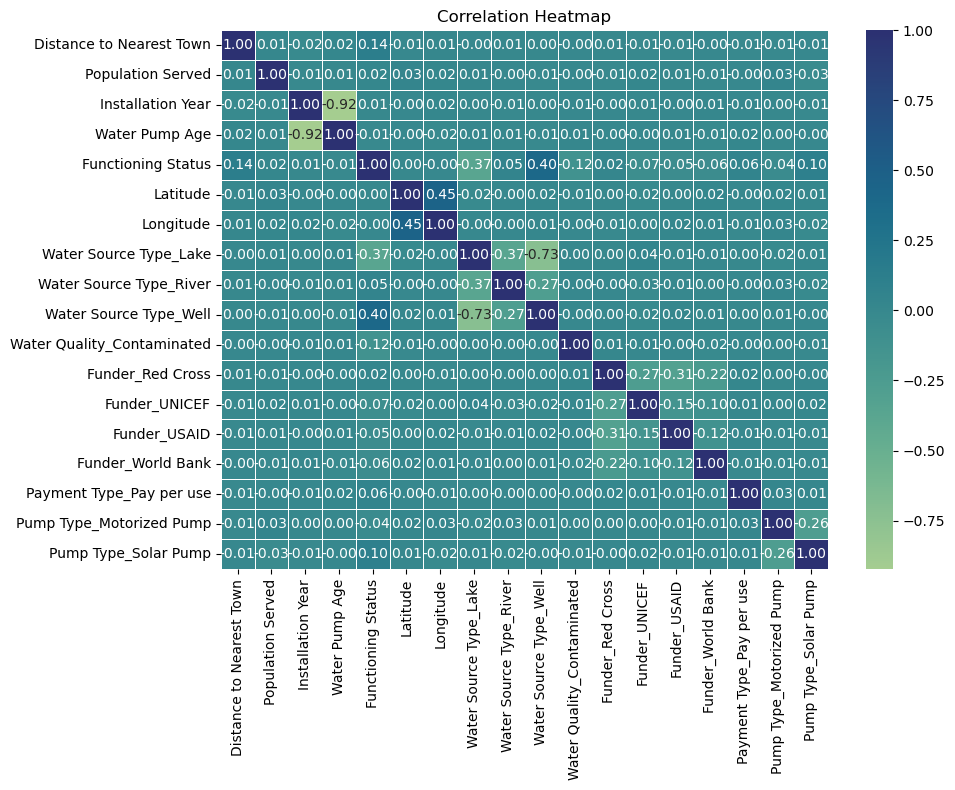

In [195]:
# Correlation matrix for numerical columns

corr = df_encoded.corr()

# Plot a heatmap with a crest-inspired colormap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='crest', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()


In [23]:
#Since water pump age and Installation Year are strongly negatively corelated, therefore it is reasonale to keep one as it could reduce collinearity and one feature is enough to tell about another in this case. 

# This will remove the column from df_encoded
df_encoded = df_encoded.drop(columns=['Installation Year'])

# Check to confirm it's gone
print("\n Updated Column Names:\n", df_encoded.columns.tolist())


 Updated Column Names:
 ['Distance to Nearest Town', 'Population Served', 'Water Pump Age', 'Functioning Status', 'Latitude', 'Longitude', 'Water Source Type_Lake', 'Water Source Type_River', 'Water Source Type_Well', 'Water Quality_Contaminated', 'Funder_Red Cross', 'Funder_UNICEF', 'Funder_USAID', 'Funder_World Bank', 'Payment Type_Pay per use', 'Pump Type_Motorized Pump', 'Pump Type_Solar Pump']


Functioning Status
Not Functioning    2939
Functioning        2061
Name: count, dtype: int64
Functioning Status
Not Functioning    0.5878
Functioning        0.4122
Name: proportion, dtype: float64


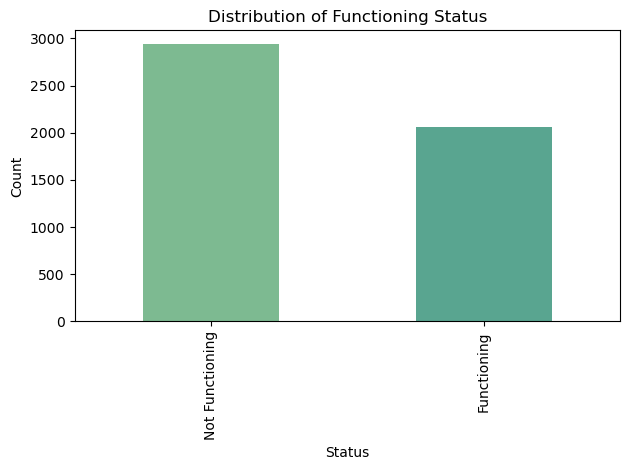

In [197]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define crest palette
palette = sns.color_palette("crest", n_colors=6)

# Check the balance of the target variable
print(df['Functioning Status'].value_counts())
print(df['Functioning Status'].value_counts(normalize=True))

# Bar plot using crest colors
status_counts = df['Functioning Status'].value_counts()
status_counts.plot(kind='bar', color=palette[:len(status_counts)])

plt.title('Distribution of Functioning Status')
plt.xlabel('Status')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [25]:
#Preparing for Modelling

# Define feature columns and target
X = df_encoded.drop(columns=['Functioning Status'])
y = df_encoded['Functioning Status']

# Split first
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Apply SMOTE to training set
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

# Scale numeric columns
scaler = StandardScaler()
numeric_cols = ['Distance to Nearest Town', 'Population Served', 'Water Pump Age', 'Latitude', 'Longitude']

X_res[numeric_cols] = scaler.fit_transform(X_res[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [199]:
#Modelling starts; Logistic Regression

Basic Logistic Regression
Train Accuracy: 0.7613
Test Accuracy: 0.7347


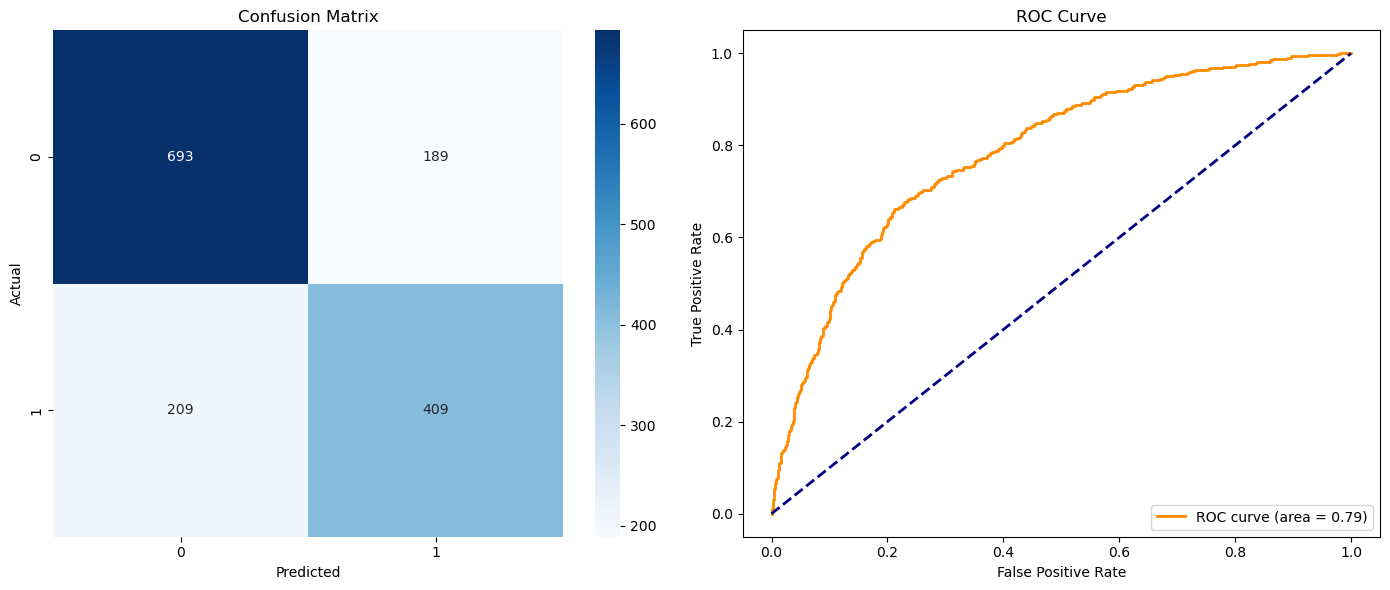


Classification Report (Test Data):

              precision    recall  f1-score   support

           0       0.77      0.79      0.78       882
           1       0.68      0.66      0.67       618

    accuracy                           0.73      1500
   macro avg       0.73      0.72      0.72      1500
weighted avg       0.73      0.73      0.73      1500

Log Loss: 0.5497


In [200]:
#Basic Logistic Regression

model1 = LogisticRegression(max_iter=1000)
model1.fit(X_res, y_res)

train_acc1 = model1.score(X_res, y_res)
test_acc1 = model1.score(X_test, y_test)
y_test_pred1 = model1.predict(X_test)
y_pred_proba1 = model1.predict_proba(X_test)

print("Basic Logistic Regression")
print(f"Train Accuracy: {train_acc1:.4f}")
print(f"Test Accuracy: {test_acc1:.4f}")

# Create a figure with 1 row and 2 columns 
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  

# Plot Confusion Matrix on the first subplot 
cm = confusion_matrix(y_test, y_test_pred1)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["0", "1"], yticklabels=["0", "1"], 
            ax=axes[0])  
axes[0].set_title("Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# Plot ROC Curve on the second subplot 
roc_auc = roc_auc_score(y_test, y_pred_proba1[:, 1])
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba1[:, 1])
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend(loc='lower right')

# 4. Adjust layout 
plt.tight_layout()  
plt.show()  

print("\nClassification Report (Test Data):\n")
print(classification_report(y_test, y_test_pred1))

logloss1 = log_loss(y_test, y_pred_proba1)
print(f"Log Loss: {logloss1:.4f}")


Logistic Regression with Regularization (Model 2)
Train Accuracy: 0.7613
Test Accuracy: 0.7347
Cross-Validated Accuracy: 0.7574
Log Loss: 0.5497


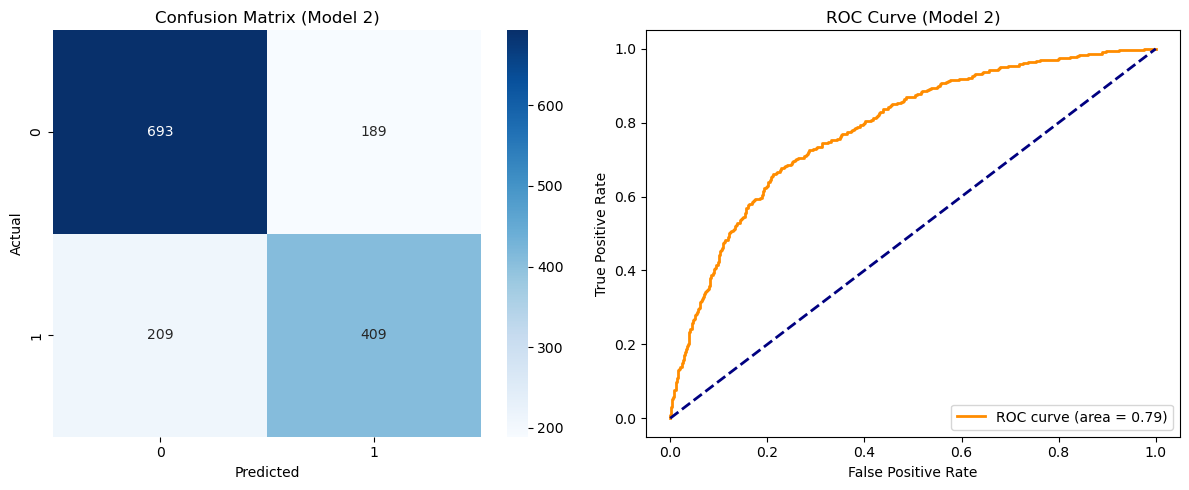


Classification Report (Test Data):

              precision    recall  f1-score   support

           0       0.77      0.79      0.78       882
           1       0.68      0.66      0.67       618

    accuracy                           0.73      1500
   macro avg       0.73      0.72      0.72      1500
weighted avg       0.73      0.73      0.73      1500



In [201]:
#Logistic Regression with Regularization

model2 = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=1000)
model2.fit(X_res, y_res)

train_acc2 = model2.score(X_res, y_res)
test_acc2 = model2.score(X_test, y_test)

cv_acc2 = cross_val_score(model2, X_res, y_res, cv=5, scoring='accuracy').mean()

# Predictions
y_test_pred2 = model2.predict(X_test)
y_pred_proba2 = model2.predict_proba(X_test)

# Log Loss
logloss2 = log_loss(y_test, y_pred_proba2)

print("\nLogistic Regression with Regularization (Model 2)")
print(f"Train Accuracy: {train_acc2:.4f}")
print(f"Test Accuracy: {test_acc2:.4f}")
print(f"Cross-Validated Accuracy: {cv_acc2:.4f}")
print(f"Log Loss: {logloss2:.4f}")

# Evaluation Metrics
cm = confusion_matrix(y_test, y_test_pred2)
roc_auc = roc_auc_score(y_test, y_pred_proba2[:, 1])
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba2[:, 1])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"], ax=axes[0])
axes[0].set_title("Confusion Matrix (Model 2)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# ROC Curve
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve (Model 2)')
axes[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

# 3. Classification Report
print("\nClassification Report (Test Data):\n")
print(classification_report(y_test, y_test_pred2))


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression with RFE (Model 4)
Train Accuracy: 0.7248
Test Accuracy: 0.7273
Cross-Validated Accuracy: 0.7205
Log Loss: 0.5712


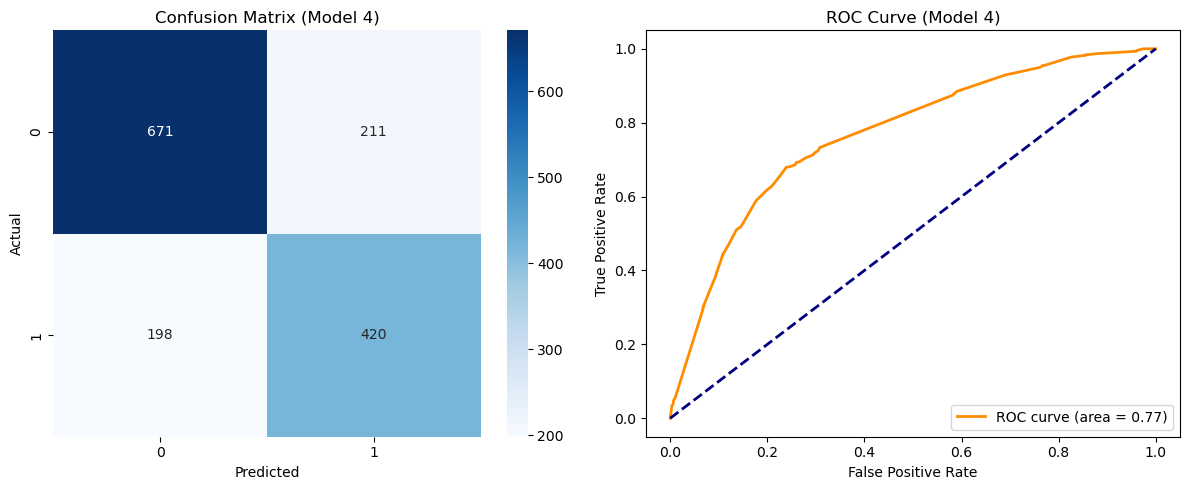


Classification Report (Test Data):

              precision    recall  f1-score   support

           0       0.77      0.76      0.77       882
           1       0.67      0.68      0.67       618

    accuracy                           0.73      1500
   macro avg       0.72      0.72      0.72      1500
weighted avg       0.73      0.73      0.73      1500



In [202]:
# Logistic Regression with RFE (with SMOTE after RFE)

# Feature selection
base_model = LogisticRegression(max_iter=1000)
selector = RFE(base_model, n_features_to_select=8)
selector.fit(X_train, y_train)

X_train_rfe = selector.transform(X_train)
X_test_rfe = selector.transform(X_test)

# Apply SMOTE after RFE
X_rfe_res, y_rfe_res = SMOTE(random_state=42).fit_resample(X_train_rfe, y_train)

model4 = LogisticRegression(max_iter=1000)
model4.fit(X_rfe_res, y_rfe_res)

train_acc4 = model4.score(X_rfe_res, y_rfe_res)
test_acc4 = model4.score(X_test_rfe, y_test)

cv_acc4 = cross_val_score(model4, X_rfe_res, y_rfe_res, cv=5, scoring='accuracy').mean()

y_test_pred4 = model4.predict(X_test_rfe)
y_pred_proba4 = model4.predict_proba(X_test_rfe)
logloss4 = log_loss(y_test, y_pred_proba4)

print("\nLogistic Regression with RFE (Model 4)")
print(f"Train Accuracy: {train_acc4:.4f}")
print(f"Test Accuracy: {test_acc4:.4f}")
print(f"Cross-Validated Accuracy: {cv_acc4:.4f}")
print(f"Log Loss: {logloss4:.4f}")

# Evaluation Metrics
cm = confusion_matrix(y_test, y_test_pred4)
roc_auc = roc_auc_score(y_test, y_pred_proba4[:, 1])
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba4[:, 1])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"], ax=axes[0])
axes[0].set_title("Confusion Matrix (Model 4)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# ROC Curve
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve (Model 4)')
axes[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

print("\nClassification Report (Test Data):\n")
print(classification_report(y_test, y_test_pred4))



Logistic Regression with Polynomial Features (Model 5)
Train Accuracy: 0.7776
Test Accuracy: 0.7347
Log Loss: 0.5587


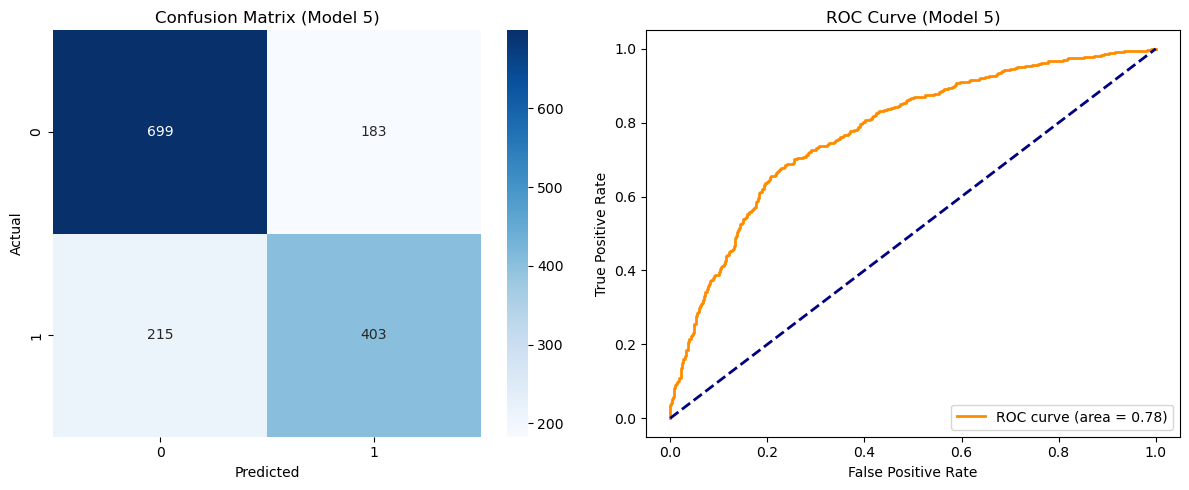


Classification Report (Test Data):

              precision    recall  f1-score   support

           0       0.76      0.79      0.78       882
           1       0.69      0.65      0.67       618

    accuracy                           0.73      1500
   macro avg       0.73      0.72      0.72      1500
weighted avg       0.73      0.73      0.73      1500



In [203]:
#Logistic Regression with Polynomial Features

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly_train = poly.fit_transform(X_res)
X_poly_test = poly.transform(X_test)

model5 = LogisticRegression(max_iter=1000)
model5.fit(X_poly_train, y_res)

train_acc5 = model5.score(X_poly_train, y_res)
test_acc5 = model5.score(X_poly_test, y_test)

y_test_pred5 = model5.predict(X_poly_test)
y_pred_proba5 = model5.predict_proba(X_poly_test)
logloss5 = log_loss(y_test, y_pred_proba5)

print("\nLogistic Regression with Polynomial Features (Model 5)")
print(f"Train Accuracy: {train_acc5:.4f}")
print(f"Test Accuracy: {test_acc5:.4f}")
print(f"Log Loss: {logloss5:.4f}")

# Evaluation Metrics
cm = confusion_matrix(y_test, y_test_pred5)
roc_auc = roc_auc_score(y_test, y_pred_proba5[:, 1])
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba5[:, 1])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"], ax=axes[0])
axes[0].set_title("Confusion Matrix (Model 5)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# ROC Curve
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve (Model 5)')
axes[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

print("\nClassification Report (Test Data):\n")
print(classification_report(y_test, y_test_pred5))



Logistic Regression with Hyperparameter Tuning (Model 6)
Best Params: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Train Accuracy: 0.7642
Test Accuracy: 0.7233
Log Loss: 0.5519


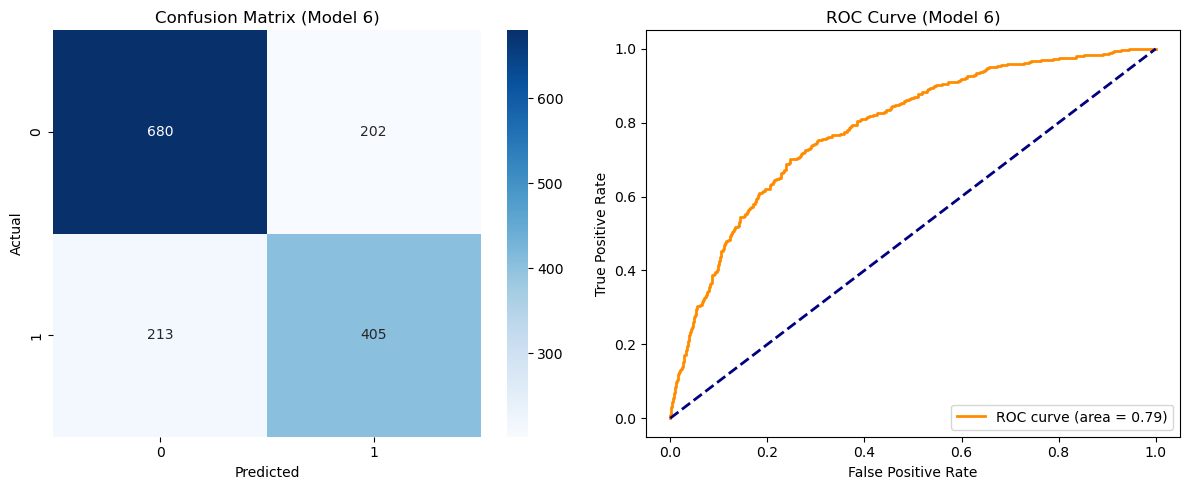


Classification Report (Test Data):

              precision    recall  f1-score   support

           0       0.76      0.77      0.77       882
           1       0.67      0.66      0.66       618

    accuracy                           0.72      1500
   macro avg       0.71      0.71      0.71      1500
weighted avg       0.72      0.72      0.72      1500



In [204]:
# Logistic Regression with GridSearchCV (Hyperparameter Tuning)

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
grid_model = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5)
grid_model.fit(X_res, y_res)

train_acc6 = grid_model.score(X_res, y_res)
test_acc6 = grid_model.score(X_test, y_test)

y_test_pred6 = grid_model.predict(X_test)
y_pred_proba6 = grid_model.predict_proba(X_test)
logloss6 = log_loss(y_test, y_pred_proba6)

print("\nLogistic Regression with Hyperparameter Tuning (Model 6)")
print(f"Best Params: {grid_model.best_params_}")
print(f"Train Accuracy: {train_acc6:.4f}")
print(f"Test Accuracy: {test_acc6:.4f}")
print(f"Log Loss: {logloss6:.4f}")

# Evaluation Metrics
cm = confusion_matrix(y_test, y_test_pred6)
roc_auc = roc_auc_score(y_test, y_pred_proba6[:, 1])
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba6[:, 1])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"], ax=axes[0])
axes[0].set_title("Confusion Matrix (Model 6)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# ROC Curve
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve (Model 6)')
axes[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

print("\nClassification Report (Test Data):\n")
print(classification_report(y_test, y_test_pred6))


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Common important features across RFE, L1, and Coefficients:
 {'Funder_World Bank', 'Funder_USAID', 'Funder_UNICEF', 'Payment Type_Pay per use', 'Pump Type_Solar Pump', 'Water Source Type_River', 'Water Source Type_Well', 'Water Quality_Contaminated'}


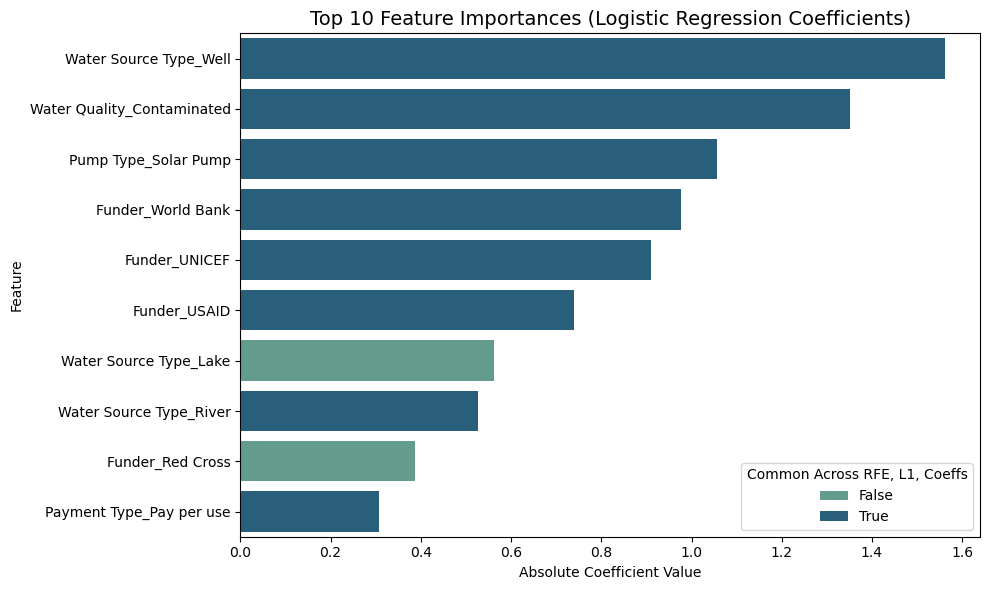


Logistic Regression with Selected Features
Train Accuracy (Selected Features): 0.7311
Test Accuracy (Selected Features): 0.7253
Log Loss: 0.5605


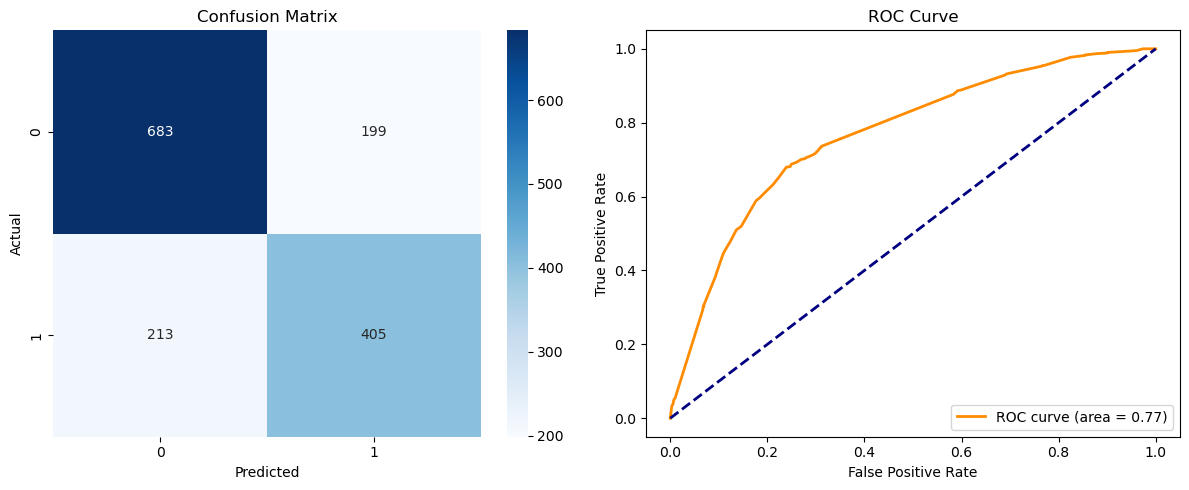


Classification Report (Test Data):

              precision    recall  f1-score   support

           0       0.76      0.77      0.77       882
           1       0.67      0.66      0.66       618

    accuracy                           0.73      1500
   macro avg       0.72      0.71      0.72      1500
weighted avg       0.72      0.73      0.72      1500



In [205]:
#Feature Importance Intersection (Extra analysis)

# Feature importance
base_model = LogisticRegression(max_iter=1000, solver='liblinear')
rfe = RFE(base_model, n_features_to_select=8)
rfe.fit(X_train, y_train)
rfe_features = X_train.columns[rfe.support_]

l1_model = LogisticRegression(penalty='l1', solver='liblinear', C=1, max_iter=1000)
l1_model.fit(X_train, y_train)
l1_features = X_train.columns[(l1_model.coef_[0] != 0)]

basic_model = LogisticRegression(max_iter=1000)
basic_model.fit(X_train, y_train)
coeff_basic = pd.Series(basic_model.coef_[0], index=X_train.columns)
top_basic = coeff_basic.abs().sort_values(ascending=False).head(10).index

common_features = set(rfe_features) & set(l1_features) & set(top_basic)
print("Common important features across RFE, L1, and Coefficients:\n", common_features)

# Plot
palette = sns.color_palette("crest", n_colors=6)
sorted_coeffs = coeff_basic.abs().sort_values(ascending=False).head(10)

feature_importance_df = pd.DataFrame({
    'Feature': sorted_coeffs.index,
    'Importance': sorted_coeffs.values,
    'Common': sorted_coeffs.index.isin(common_features)
})
custom_colors = {True: palette[4], False: palette[1]}
plt.figure(figsize=(10, 6))
sns.barplot(
    data=feature_importance_df,
    x='Importance',
    y='Feature',
    hue='Common',
    dodge=False,
    palette=custom_colors
)
plt.title('Top 10 Feature Importances (Logistic Regression Coefficients)', fontsize=14)
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.legend(title='Common Across RFE, L1, Coeffs')
plt.tight_layout()
plt.show()

# Select only the common important features
X_train_selected = X_train[list(common_features)]
X_test_selected = X_test[list(common_features)]

# Build the model
model_selected = LogisticRegression(max_iter=1000, solver='liblinear')
model_selected.fit(X_train_selected, y_train)

# Predict on train and test data
y_train_pred = model_selected.predict(X_train_selected)
y_test_pred = model_selected.predict(X_test_selected)
y_pred_proba_selected = model_selected.predict_proba(X_test_selected)

# Evaluate
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
logloss_selected = log_loss(y_test, y_pred_proba_selected)

print("\nLogistic Regression with Selected Features")
print(f"Train Accuracy (Selected Features): {train_accuracy:.4f}")
print(f"Test Accuracy (Selected Features): {test_accuracy:.4f}")
print(f"Log Loss: {logloss_selected:.4f}")

# Metrics
cm = confusion_matrix(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba_selected[:, 1])
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_selected[:, 1])

# Set up side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["0", "1"], 
            yticklabels=["0", "1"], 
            ax=axes[0])
axes[0].set_title("Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# ROC Curve
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

print("\nClassification Report (Test Data):\n")
print(classification_report(y_test, y_test_pred))


In [206]:
#Decision Tree Modelling

In [207]:
# Define a function to evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name="Model"):
    print(f"\n=== {model_name} ===")
    
    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Probabilities for ROC
    if hasattr(model, "predict_proba"):
        y_probs_test = model.predict_proba(X_test)[:, 1]
    else:
        y_probs_test = None
    
    # Accuracy
    print(f"Train Accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
    print(f"Test Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
    
    # Precision, Recall, F1-Score
    print("\nClassification Report (Test Data):")
    print(classification_report(y_test, y_pred_test))
    
    # ROC-AUC
    if y_probs_test is not None:
        roc_auc = roc_auc_score(y_test, y_probs_test)
        print(f"ROC-AUC Score (Test Data): {roc_auc:.4f}")
    
    # 5-fold Cross Validation Accuracy
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"Cross-Validation Accuracy (mean ± std): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    
    # Plot Confusion Matrix and ROC Curve side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[0], values_format='d')
    axes[0].set_title(f"{model_name} - Confusion Matrix")
    
    # ROC Curve
    if y_probs_test is not None:
        fpr, tpr, _ = roc_curve(y_test, y_probs_test)
        RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=axes[1])
        axes[1].set_title(f"{model_name} - ROC Curve")
    
    plt.tight_layout()
    plt.show()


=== DECISION TREE Max_Depth=5 ===

=== Decision Tree (max_depth=5) ===
Train Accuracy: 0.7409
Test Accuracy: 0.7147

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.72      0.84      0.78       882
           1       0.70      0.53      0.61       618

    accuracy                           0.71      1500
   macro avg       0.71      0.69      0.69      1500
weighted avg       0.71      0.71      0.71      1500

ROC-AUC Score (Test Data): 0.7176
Cross-Validation Accuracy (mean ± std): 0.7157 ± 0.0209


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_plot\roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


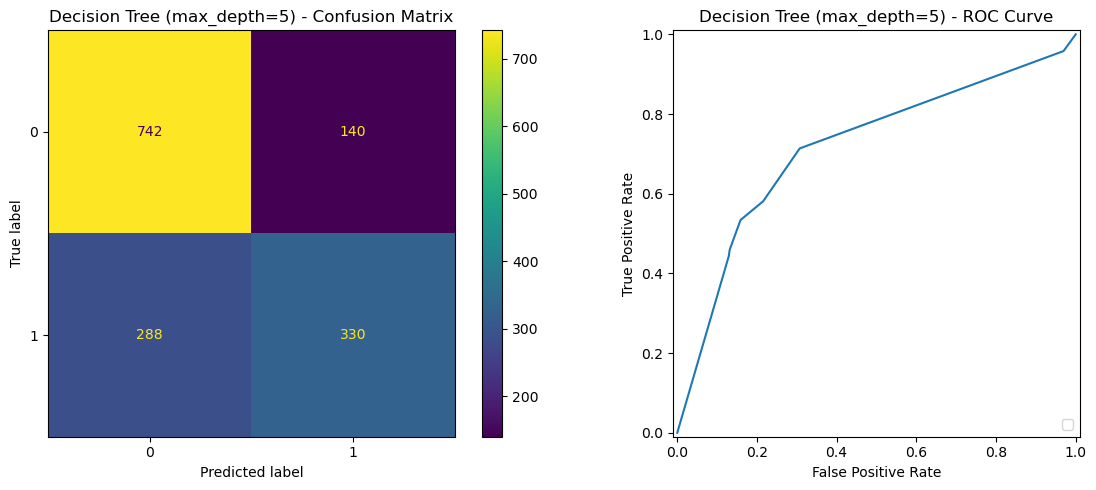


=== DECISION TREE v1 - BASIC ===

=== Decision Tree v1 (Basic) ===
Train Accuracy: 1.0000
Test Accuracy: 0.6980

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.72      0.80      0.76       882
           1       0.66      0.55      0.60       618

    accuracy                           0.70      1500
   macro avg       0.69      0.68      0.68      1500
weighted avg       0.69      0.70      0.69      1500

ROC-AUC Score (Test Data): 0.6764
Cross-Validation Accuracy (mean ± std): 0.6220 ± 0.0100


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_plot\roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


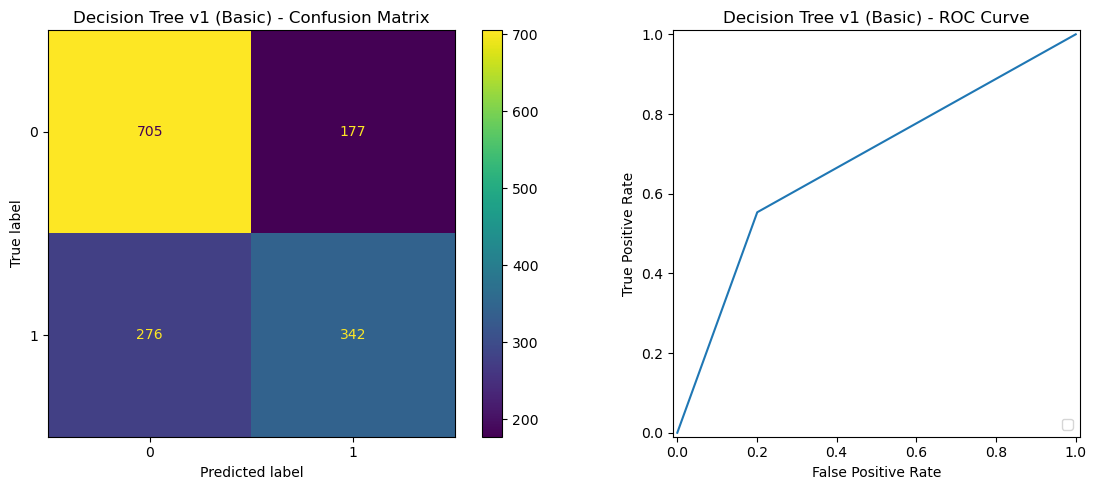


=== DECISION TREE v2 - Tuned max_depth=6 ===

=== Decision Tree v2 (max_depth=6) ===
Train Accuracy: 0.7511
Test Accuracy: 0.7093

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.71      0.84      0.77       882
           1       0.70      0.52      0.59       618

    accuracy                           0.71      1500
   macro avg       0.71      0.68      0.68      1500
weighted avg       0.71      0.71      0.70      1500

ROC-AUC Score (Test Data): 0.7024
Cross-Validation Accuracy (mean ± std): 0.7120 ± 0.0132


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_plot\roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


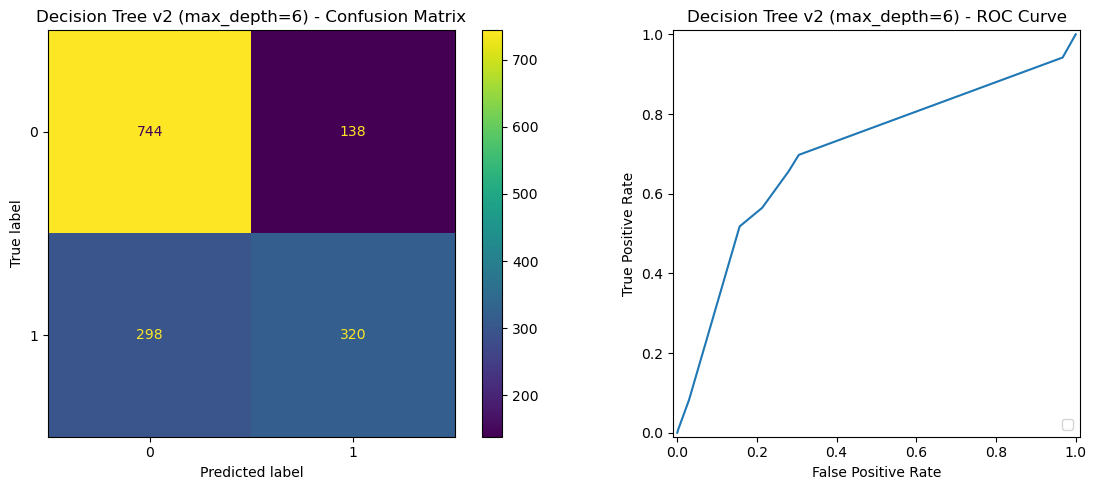


=== DECISION TREE v3 - Entropy, Depth=8, Min Split=10 ===

=== Decision Tree v3 (Entropy, depth=8, split=10) ===
Train Accuracy: 0.7691
Test Accuracy: 0.6853

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.68      0.88      0.77       882
           1       0.70      0.41      0.52       618

    accuracy                           0.69      1500
   macro avg       0.69      0.64      0.64      1500
weighted avg       0.69      0.69      0.66      1500

ROC-AUC Score (Test Data): 0.6645
Cross-Validation Accuracy (mean ± std): 0.7051 ± 0.0195


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_plot\roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


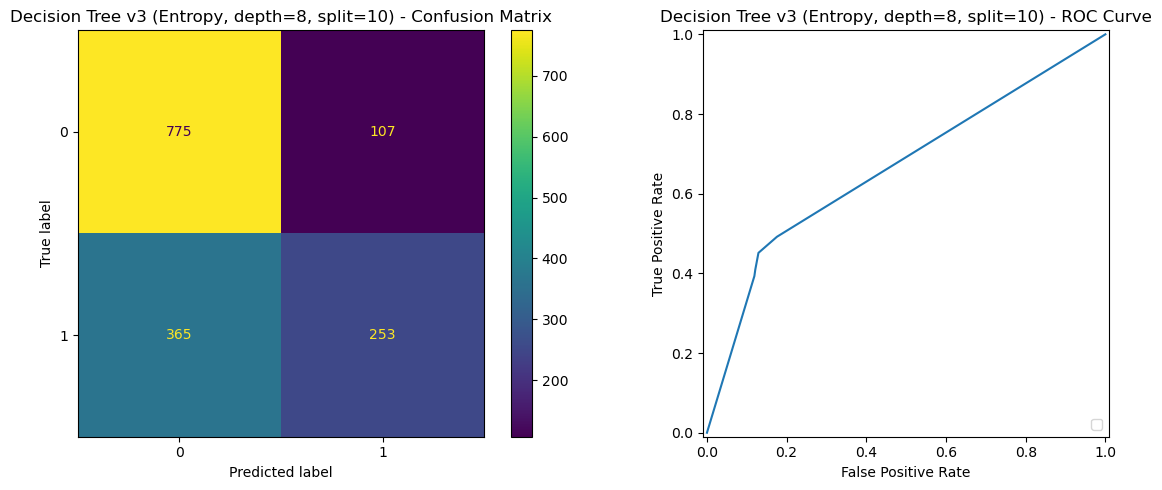


=== DECISION TREE - Tuned with SMOTE + Feature Selection ===

Best Parameters from Grid Search: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 2}

=== Tuned Decision Tree (GridSearch) ===
Train Accuracy: 0.7518
Test Accuracy: 0.5880

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.59      1.00      0.74       882
           1       0.00      0.00      0.00       618

    accuracy                           0.59      1500
   macro avg       0.29      0.50      0.37      1500
weighted avg       0.35      0.59      0.44      1500

ROC-AUC Score (Test Data): 0.6864
Cross-Validation Accuracy (mean ± std): 0.7241 ± 0.0416


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\m

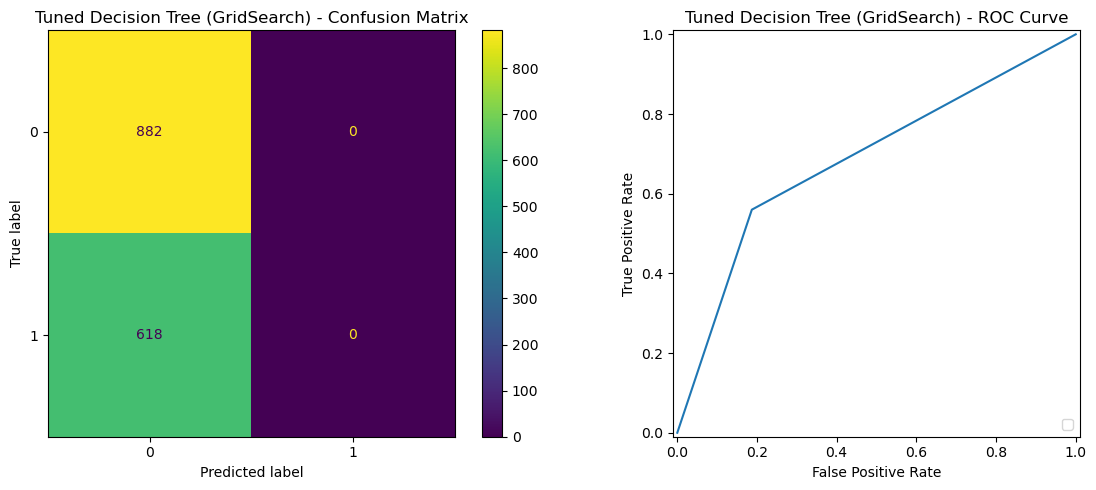

In [208]:
# Model 0
print("\n=== DECISION TREE Max_Depth=5 ===")
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train, y_train)
evaluate_model(dt, X_train, y_train, X_test, y_test, model_name="Decision Tree (max_depth=5)")

# Model 1
print("\n=== DECISION TREE v1 - BASIC ===")
dt1 = DecisionTreeClassifier(random_state=42)
dt1.fit(X_train, y_train)
evaluate_model(dt1, X_train, y_train, X_test, y_test, model_name="Decision Tree v1 (Basic)")

# Model 2
print("\n=== DECISION TREE v2 - Tuned max_depth=6 ===")
dt2 = DecisionTreeClassifier(max_depth=6, random_state=42)
dt2.fit(X_train, y_train)
evaluate_model(dt2, X_train, y_train, X_test, y_test, model_name="Decision Tree v2 (max_depth=6)")

# Model 3
print("\n=== DECISION TREE v3 - Entropy, Depth=8, Min Split=10 ===")
dt3 = DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_split=10, random_state=42)
dt3.fit(X_train, y_train)
evaluate_model(dt3, X_train, y_train, X_test, y_test, model_name="Decision Tree v3 (Entropy, depth=8, split=10)")

# Model 4 (Tuned Decision Tree)
print("\n=== DECISION TREE - Tuned with SMOTE + Feature Selection ===")
# SMOTE resampling
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Feature selection
selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))
selector.fit(X_train_res, y_train_res)
X_train_sel = selector.transform(X_train_res)
X_test_sel = selector.transform(X_test)

# Hyperparameter tuning
dt_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [6, 8, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'class_weight': [None, 'balanced']
}
dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=5, scoring='accuracy')
dt_grid.fit(X_train_sel, y_train_res)

dt_best = dt_grid.best_estimator_
print("\nBest Parameters from Grid Search:", dt_grid.best_params_)
evaluate_model(dt_best, X_train_sel, y_train_res, X_test_sel, y_test, model_name="Tuned Decision Tree (GridSearch)")


In [209]:
#Ensemble Method

In [210]:
print("\n=== RANDOM FOREST MODELS ===")

# Helper function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    overfit_gap = train_acc - test_acc
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    
    # Metrics
    roc_auc = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred)
    
    # Print Metrics
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Overfitting Gap (Train - Test): {overfit_gap:.4f}")
    print(f"Cross-Validation Score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("\nClassification Report:\n", cr)
    
    # Side-by-side Plots
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # Confusion Matrix
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax[0])
    ax[0].set_title('Confusion Matrix')
    ax[0].set_xlabel('Predicted')
    ax[0].set_ylabel('Actual')

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    ax[1].plot(fpr, tpr, color='darkorange')
    ax[1].plot([0, 1], [0, 1], color='navy', linestyle='--')
    ax[1].set_title('ROC Curve')
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')

    plt.tight_layout()
    plt.show()



=== RANDOM FOREST MODELS ===



Random Forest v1 - Basic:
Train Accuracy: 1.0000
Test Accuracy: 0.6420
Overfitting Gap (Train - Test): 0.3580
Cross-Validation Score: 0.7120 ± 0.0156
ROC-AUC Score: 0.7213
F1-Score: 0.4400

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.85      0.74       882
           1       0.62      0.34      0.44       618

    accuracy                           0.64      1500
   macro avg       0.63      0.60      0.59      1500
weighted avg       0.64      0.64      0.61      1500



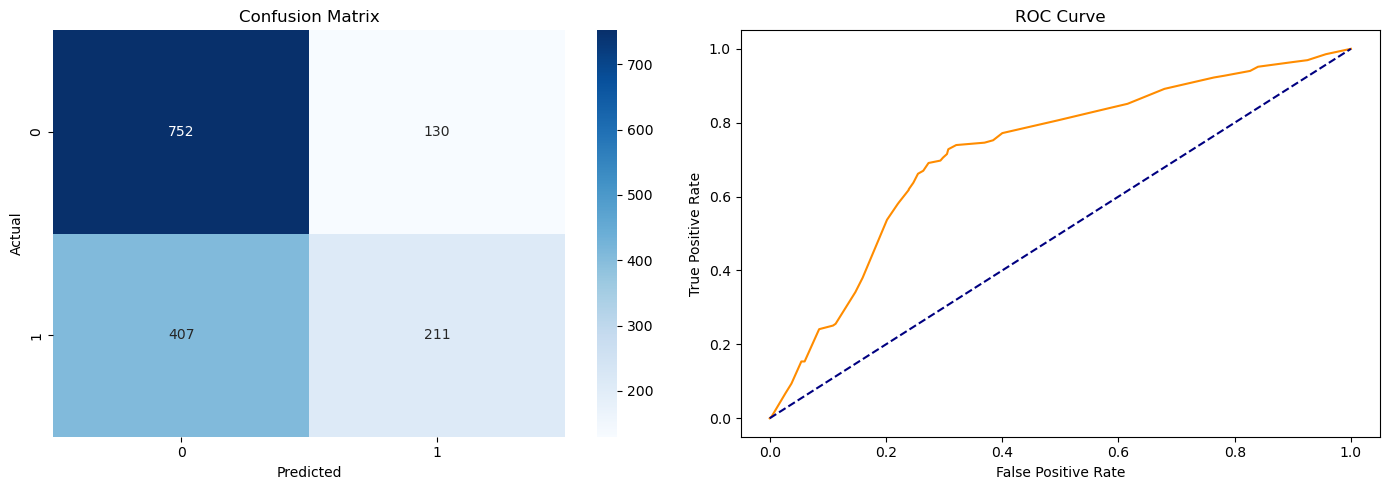


Random Forest v2 - n_estimators=100, max_depth=10:
Train Accuracy: 0.8377
Test Accuracy: 0.7153
Overfitting Gap (Train - Test): 0.1224
Cross-Validation Score: 0.7249 ± 0.0200
ROC-AUC Score: 0.7423
F1-Score: 0.6050

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.85      0.78       882
           1       0.71      0.53      0.60       618

    accuracy                           0.72      1500
   macro avg       0.71      0.69      0.69      1500
weighted avg       0.71      0.72      0.71      1500



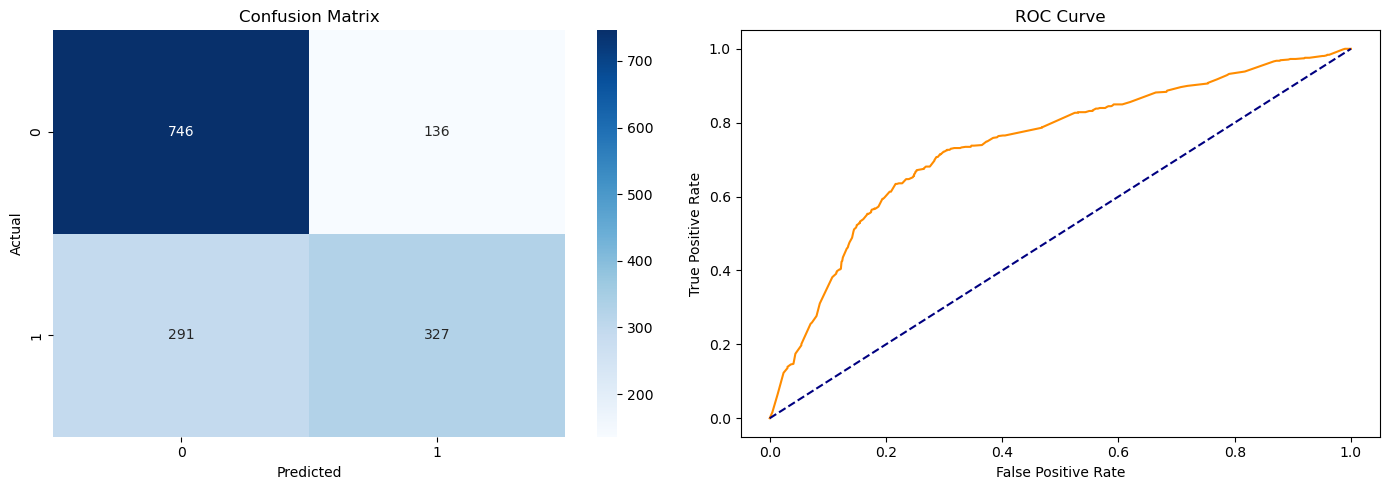

In [211]:
# Version 1: Basic Random Forest
rf1 = RandomForestClassifier(random_state=42)
rf1.fit(X_train, y_train)
print("\nRandom Forest v1 - Basic:")
evaluate_model(rf1, X_train, X_test, y_train, y_test)

# Version 2: With n_estimators and max_depth
rf2 = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf2.fit(X_train, y_train)
print("\nRandom Forest v2 - n_estimators=100, max_depth=10:")
evaluate_model(rf2, X_train, X_test, y_train, y_test)

Logistic Regression with Bagging
Train Accuracy: 0.7640
Test Accuracy: 0.7293

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.76      0.79      0.77       882
           1       0.68      0.65      0.66       618

    accuracy                           0.73      1500
   macro avg       0.72      0.72      0.72      1500
weighted avg       0.73      0.73      0.73      1500

AUC: 0.79


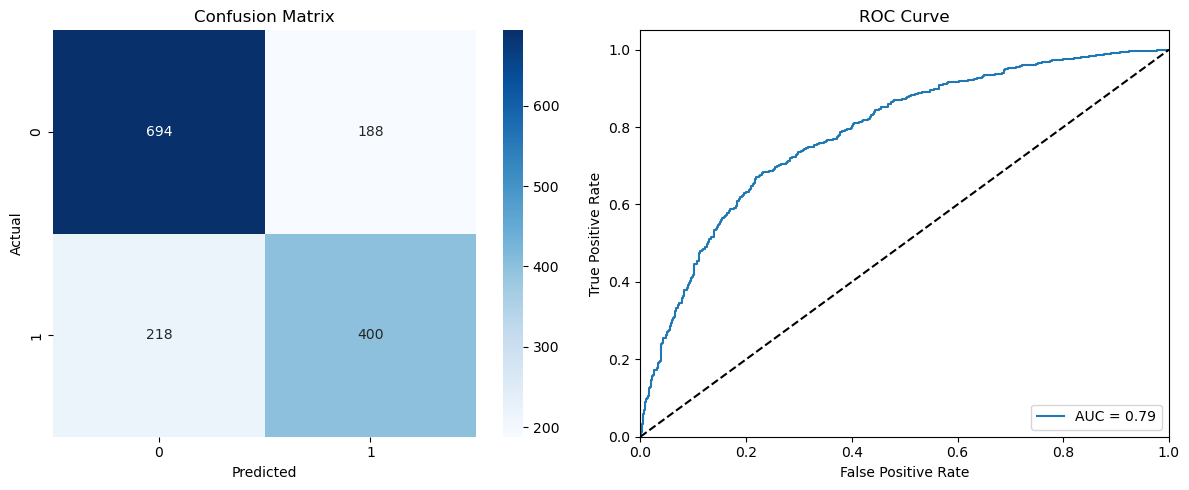

In [212]:
# Bagging with Logistic Regression
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the base model
base_model = LogisticRegression(random_state=42)

# Create the bagging ensemble (using estimator instead of base_estimator)
bagging_model = BaggingClassifier(estimator=base_model, n_estimators=10, random_state=42)

# Fit on the resampled training data
bagging_model.fit(X_res, y_res)

# Predictions
y_train_pred = bagging_model.predict(X_res)
y_test_pred = bagging_model.predict(X_test)

# Calculate probabilities for ROC curve
y_test_proba = bagging_model.predict_proba(X_test)[:, 1]

# Performance metrics
train_accuracy = accuracy_score(y_res, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Logistic Regression with Bagging")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Classification report
print("\nClassification Report (Test Data):")
print(classification_report(y_test, y_test_pred))

# ROC curve calculation
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc:.2f}")

# Plot Confusion Matrix and ROC Curve side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# ROC Curve
axes[1].plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
axes[1].plot([0, 1], [0, 1], 'k--')  # Random guess line
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()


In [213]:
#Naive Bayes

Training Accuracy (GaussianNB): 0.7392
Testing Accuracy (GaussianNB): 0.7093
No major overfitting detected for GaussianNB.


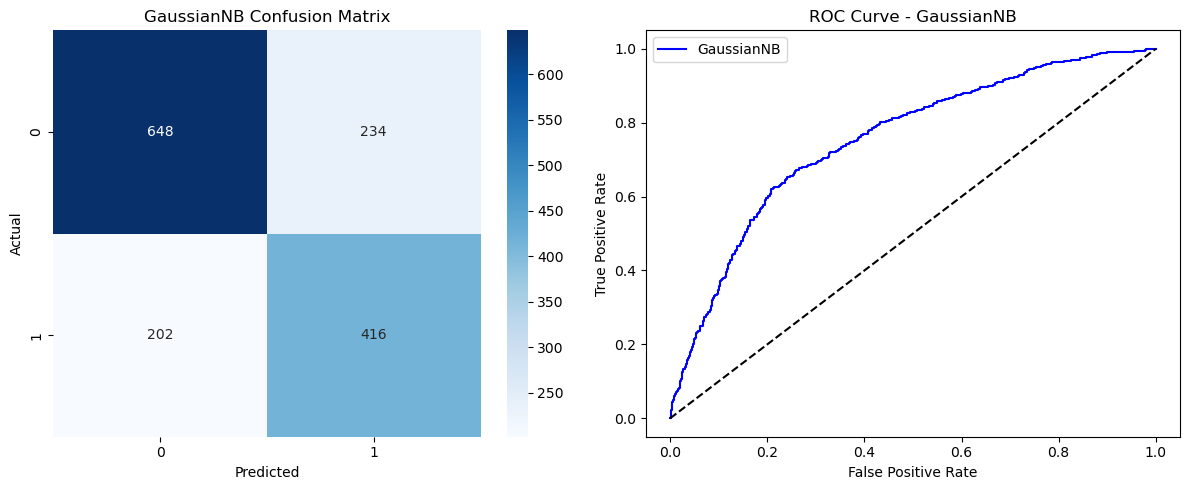

AUC Score (GaussianNB): 0.753311464823254


In [214]:
# Model 1: Gaussian Naive Bayes

# Gaussian Naive Bayes assumes features are continuous and normally distributed (Gaussian).

# Initialize the GaussianNB model and Train the model using the training data
gnb = GaussianNB()
gnb.fit(X_res, y_res)  # Corrected to use X_res and y_res

# Predict outcomes on training and testing datasets
y_train_pred = gnb.predict(X_res)
y_test_pred = gnb.predict(X_test)

# Evaluate performance by checking training and testing accuracies
train_acc_gnb = accuracy_score(y_res, y_train_pred)
test_acc_gnb = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy (GaussianNB): {train_acc_gnb:.4f}")
print(f"Testing Accuracy (GaussianNB): {test_acc_gnb:.4f}")

# Overfitting check
if abs(train_acc_gnb - test_acc_gnb) < 0.05:
    print("No major overfitting detected for GaussianNB.")
else:
    print("Possible overfitting detected for GaussianNB.")

# To visualize performance:
# Confusion Matrix and ROC Curve Side-by-Side
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test_pred),
            yticklabels=np.unique(y_test), ax=axes[0])
axes[0].set_title("GaussianNB Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# ROC Curve
y_test_binary = y_test.astype(int)

y_probs = gnb.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test_binary, y_probs)

axes[1].plot(fpr, tpr, color='blue', label='GaussianNB')
axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_title("ROC Curve - GaussianNB")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].legend()

plt.tight_layout()
plt.show()

print("AUC Score (GaussianNB):", roc_auc_score(y_test_binary, y_probs))

Top 20 features selected based on highest correlation:
 ['Population Served', 'Water Pump Age', 'Latitude', 'Longitude', 'Water Source Type_Lake', 'Water Source Type_River', 'Water Source Type_Well', 'Water Quality_Contaminated', 'Funder_Red Cross', 'Funder_UNICEF', 'Funder_USAID', 'Funder_World Bank', 'Payment Type_Pay per use', 'Pump Type_Motorized Pump', 'Pump Type_Solar Pump']
Training Accuracy (GaussianNB with Top Features): 0.7329
Testing Accuracy (GaussianNB with Top Features): 0.7053


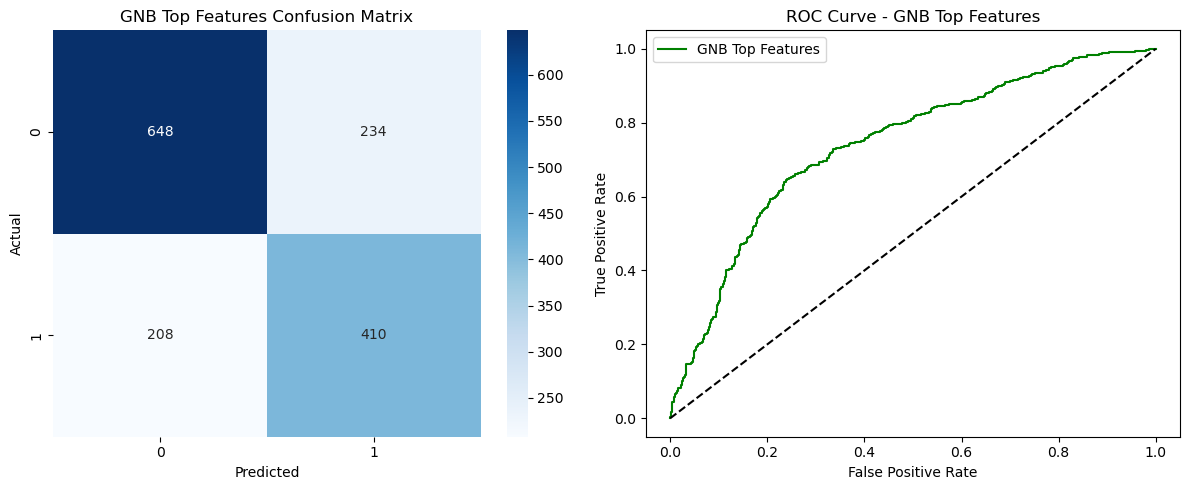

AUC Score (GNB Top Features): 0.7405554454791625


In [215]:
# Method 2. GaussianNB Improvement: Manual Top Feature Selection
# ------------------------------------------------------------------------

# Step 1: Map 'Functioning' and 'Not Functioning' to binary (0/1)
y_binary = y.map({'Not Functioning': 0, 'Functioning': 1})

# Temporarily add the binary target to feature dataframe
df_temp = X.copy()
df_temp['Functioning Status'] = y_binary.values

# Now compute correlation
correlations = df_temp.corr()['Functioning Status'].abs().sort_values(ascending=False)

# Select top 20 features most correlated with 'Functioning Status'
top_features = correlations.index[1:21]  # Exclude the target itself

# Ensure 'Functioning Status' is excluded from top_features
top_features = [feature for feature in top_features if feature != 'Functioning Status']

print("Top 20 features selected based on highest correlation:\n", top_features)

# Step 2: Subset X_res and X_test using only the selected features
X_res_top = X_res[top_features]
X_test_top = X_test[top_features]

# Step 3: Train GaussianNB on top selected features
gnb_top = GaussianNB()
gnb_top.fit(X_res_top, y_res)

# Step 4: Predict outcomes on training and testing datasets
y_train_pred_top = gnb_top.predict(X_res_top)
y_test_pred_top = gnb_top.predict(X_test_top)

# Step 5: Evaluate performance by checking training and testing accuracies
train_acc_gnb_top = accuracy_score(y_res, y_train_pred_top)
test_acc_gnb_top = accuracy_score(y_test, y_test_pred_top)

print(f"Training Accuracy (GaussianNB with Top Features): {train_acc_gnb_top:.4f}")
print(f"Testing Accuracy (GaussianNB with Top Features): {test_acc_gnb_top:.4f}")

# Confusion Matrix and ROC Curve Side-by-Side
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))

# Confusion Matrix
cm_top = confusion_matrix(y_test, y_test_pred_top)
sns.heatmap(cm_top, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test_pred_top),
            yticklabels=np.unique(y_test), ax=axes[0])
axes[0].set_title("GNB Top Features Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# ROC Curve
y_test_binary = y_test.astype(int)

y_probs_top = gnb_top.predict_proba(X_test_top)[:, 1]
fpr_top, tpr_top, _ = roc_curve(y_test_binary, y_probs_top)

axes[1].plot(fpr_top, tpr_top, color='green', label='GNB Top Features')
axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_title("ROC Curve - GNB Top Features")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].legend()

plt.tight_layout()
plt.show()

print("AUC Score (GNB Top Features):", roc_auc_score(y_test_binary, y_probs_top))

Training Accuracy (MultinomialNB): 0.7333
Testing Accuracy (MultinomialNB): 0.7093
No major overfitting detected for MultinomialNB.


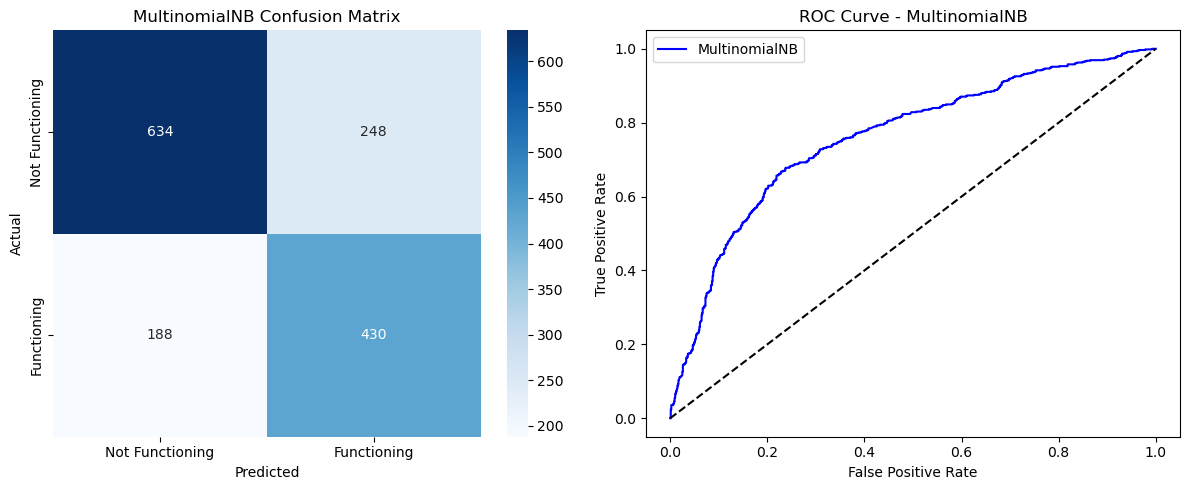

AUC Score (MultinomialNB): 0.7594968408075204


In [216]:
# Model 3: Multinomial Naive Bayes
#----------------------------------

# Clip negatives (MultinomialNB requires non-negative features)
X_res_mnb = X_res.clip(lower=0)
X_test_mnb = X_test.clip(lower=0)

# Train MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_res_mnb, y_res)

# Predict outcomes on training and testing datasets
y_train_pred_mnb = mnb.predict(X_res_mnb)
y_test_pred_mnb = mnb.predict(X_test_mnb)

# Evaluate performance by checking training and testing accuracies
train_acc_mnb = accuracy_score(y_res, y_train_pred_mnb)
test_acc_mnb = accuracy_score(y_test, y_test_pred_mnb)

print(f"Training Accuracy (MultinomialNB): {train_acc_mnb:.4f}")
print(f"Testing Accuracy (MultinomialNB): {test_acc_mnb:.4f}")

# Overfitting check
if abs(train_acc_mnb - test_acc_mnb) < 0.05:
    print("No major overfitting detected for MultinomialNB.")
else:
    print("Possible overfitting detected for MultinomialNB.")

# Visualization: Confusion Matrix + ROC Curve Side-by-Side
#-----------------------------------
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred_mnb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Functioning', 'Functioning'],
            yticklabels=['Not Functioning', 'Functioning'],
            ax=axes[0])
axes[0].set_title("MultinomialNB Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# ROC Curve
# Important: For ROC curve, make sure y_test is binary (0/1)
y_test_binary = y_test.astype(int)  # Corrected

y_probs_mnb = mnb.predict_proba(X_test_mnb)[:, 1]
fpr, tpr, _ = roc_curve(y_test_binary, y_probs_mnb)

axes[1].plot(fpr, tpr, color='blue', label='MultinomialNB')
axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_title("ROC Curve - MultinomialNB")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].legend()

plt.tight_layout()
plt.show()

print("AUC Score (MultinomialNB):", roc_auc_score(y_test_binary, y_probs_mnb))

In [217]:
#Neural network

In [218]:
# Regularization-Focused Neural Network

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, regularizers

# 1. Define early stopping
early_stop = callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
)

# 2. Define the model
model_b = keras.Sequential([
    layers.Input(shape=(X_res.shape[1],)),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),

    layers.Dense(1, activation='sigmoid')
])

# 3. Compile the model
model_b.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.AUC(name='auc')]
)

# 4. Train the model
history_b = model_b.fit(
    X_res, y_res,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# 5. Evaluate the model on Train set
train_loss_b, train_accuracy_b, train_auc_b = model_b.evaluate(X_res, y_res, verbose=0)

# 6. Evaluate the model on Test set
test_loss_b, test_accuracy_b, test_auc_b = model_b.evaluate(X_test, y_test, verbose=0)

# 7. Print Results
print("\n--- Final Evaluation: Model -Regularization-Focused ---")
print(f"Train Loss: {train_loss_b:.4f}")
print(f"Train Accuracy: {train_accuracy_b:.4f}")
print(f"Train AUC: {train_auc_b:.4f}")

print(f"\nTest Loss: {test_loss_b:.4f}")
print(f"Test Accuracy: {test_accuracy_b:.4f}")
print(f"Test AUC: {test_auc_b:.4f}")


Epoch 1/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6238 - auc: 0.6661 - loss: 1.7543 - val_accuracy: 0.6840 - val_auc: 0.7539 - val_loss: 1.4060
Epoch 2/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7050 - auc: 0.7659 - loss: 1.2984 - val_accuracy: 0.7060 - val_auc: 0.7672 - val_loss: 1.1657
Epoch 3/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7329 - auc: 0.8042 - loss: 1.0748 - val_accuracy: 0.7173 - val_auc: 0.7637 - val_loss: 1.0136
Epoch 4/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7345 - auc: 0.8027 - loss: 0.9514 - val_accuracy: 0.7213 - val_auc: 0.7685 - val_loss: 0.9045
Epoch 5/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7333 - auc: 0.8043 - loss: 0.8595 - val_accuracy: 0.7213 - val_auc: 0.7738 - val_loss: 0.8365
Epoch 6/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7334 - auc: 0.8084 - loss: 0.7880 - val_accuracy: 0.7173 - val_auc: 0.7636 - val_loss: 0.7890
Epoch 7/100
129/129 ━━━━━━━━━━━━━━

In [219]:
# High-Dropout Stability Neural Network

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, regularizers

# 1. Define early stopping to prevent overfitting
early_stop = callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=15,  # Increased patience for better stability
    restore_best_weights=True
)

# 2. Define the model with adjusted architecture
model = keras.Sequential([
    layers.Input(shape=(X_res.shape[1],)),
    
    # First hidden layer with L2 regularization and increased dropout
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.005)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),  # Increased dropout to reduce overfitting

    # Second hidden layer with L2 regularization and increased dropout
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.005)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),  # Increased dropout to reduce overfitting

    # Output layer
    layers.Dense(1, activation='sigmoid')  # Single output neuron for binary classification
])

# 3. Compile the model with a slightly reduced learning rate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),  # Slightly reduced learning rate
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.AUC(name='auc')]
)

# 4. Train the model
history = model.fit(
    X_res, y_res,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# 5. Evaluate the model on Train set
train_loss, train_accuracy, train_auc = model.evaluate(X_res, y_res, verbose=0)

# 6. Evaluate the model on Test set
test_loss, test_accuracy, test_auc = model.evaluate(X_test, y_test, verbose=0)

# 7. Print Results
print("\n--- Final Evaluation -High-Dropout Stability ---")
print(f"Train Loss: {train_loss:.4f}")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Train AUC: {train_auc:.4f}")

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")


Epoch 1/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5121 - auc: 0.5115 - loss: 1.2659 - val_accuracy: 0.5953 - val_auc: 0.6681 - val_loss: 0.9960
Epoch 2/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5892 - auc: 0.6204 - loss: 1.0778 - val_accuracy: 0.6673 - val_auc: 0.7240 - val_loss: 0.9413
Epoch 3/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6292 - auc: 0.6763 - loss: 1.0018 - val_accuracy: 0.6873 - val_auc: 0.7435 - val_loss: 0.8984
Epoch 4/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6717 - auc: 0.7155 - loss: 0.9387 - val_accuracy: 0.7033 - val_auc: 0.7516 - val_loss: 0.8700
Epoch 5/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6600 - auc: 0.7184 - loss: 0.9094 - val_accuracy: 0.7127 - val_auc: 0.7566 - val_loss: 0.8455
Epoch 6/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6725 - auc: 0.7382 - loss: 0.8752 - val_accuracy: 0.7160 - val_auc: 0.7601 - val_loss: 0.8271
Epoch 7/100
129/129 ━━━━━━━━━━━━━━

In [27]:
# Deep Dropout-Enhanced Neural Network with Feature Dropping

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from tensorflow import keras
from tensorflow.keras import layers, callbacks

# --- STEP 1: Create copies and drop selected columns ---
X_res_nn = X_res.copy()
X_test_nn = X_test.copy()

columns_to_drop_nn = [
    'Latitude', 'Longitude',
    'Funder_Red Cross', 'Funder_UNICEF', 'Funder_USAID', 'Funder_World Bank',
    'Payment Type_Pay per use'
]

X_res_nn = X_res_nn.drop(columns=[col for col in columns_to_drop_nn if col in X_res_nn.columns])
X_test_nn = X_test_nn.drop(columns=[col for col in columns_to_drop_nn if col in X_test_nn.columns])

# --- STEP 2: Define early stopping ---
early_stop = callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
)

# --- STEP 3: Define the model ---
model = keras.Sequential([
    layers.Input(shape=(X_res_nn.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(1, activation='sigmoid')
])

# --- STEP 4: Compile the model ---
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.AUC(name='auc')]
)

# --- STEP 5: Train the model ---
history = model.fit(
    X_res_nn, y_res,
    validation_data=(X_test_nn, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# --- STEP 6: Evaluate the model ---
train_loss, train_accuracy, train_auc = model.evaluate(X_res_nn, y_res, verbose=0)
test_loss, test_accuracy, test_auc = model.evaluate(X_test_nn, y_test, verbose=0)

# --- STEP 7: Print results ---
print("\n--- Final Evaluation - Deep Dropout-Enhanced Neural Network ---")
print(f"Train Loss: {train_loss:.4f}")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Train AUC: {train_auc:.4f}")
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# --- STEP 8: Save predictions ---
y_pred_prob = model.predict(X_test_nn)
y_pred = (y_pred_prob > 0.5).astype(int)


Epoch 1/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6154 - auc: 0.6448 - loss: 0.7205 - val_accuracy: 0.6213 - val_auc: 0.7393 - val_loss: 0.6542
Epoch 2/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6584 - auc: 0.7116 - loss: 0.6453 - val_accuracy: 0.6893 - val_auc: 0.7537 - val_loss: 0.6139
Epoch 3/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6939 - auc: 0.7494 - loss: 0.6034 - val_accuracy: 0.7253 - val_auc: 0.7582 - val_loss: 0.5800
Epoch 4/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7163 - auc: 0.7700 - loss: 0.5824 - val_accuracy: 0.7327 - val_auc: 0.7649 - val_loss: 0.5749
Epoch 5/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7188 - auc: 0.7717 - loss: 0.5794 - val_accuracy: 0.7260 - val_auc: 0.7662 - val_loss: 0.5731
Epoch 6/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7265 - auc: 0.7855 - loss: 0.5612 - val_accuracy: 0.7300 - val_auc: 0.7678 - val_loss: 0.5696
Epoch 7/100
129/129 ━━━━━━━━━━━━━━

In [220]:
# Deep Dropout-Enhanced Neural Network

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from tensorflow import keras
from tensorflow.keras import layers, callbacks

# 1. Early stopping to prevent overfitting
early_stop = callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
)

# 2. Define the model
model = keras.Sequential([
    layers.Input(shape=(X_res.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(1, activation='sigmoid')
])

# 3. Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.AUC(name='auc')]
)

# 4. Train the model
history = model.fit(
    X_res, y_res,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# 5. Evaluate the model
train_loss, train_accuracy, train_auc = model.evaluate(X_res, y_res, verbose=0)
test_loss, test_accuracy, test_auc = model.evaluate(X_test, y_test, verbose=0)

# 6. Print basic results
print("\n--- Final Evaluation -Deep Dropout-Enhanced Neural Network---")
print(f"Train Loss: {train_loss:.4f}")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Train AUC: {train_auc:.4f}")

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Save predictions for visualization
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)


Epoch 1/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5530 - auc: 0.5829 - loss: 0.7826 - val_accuracy: 0.6380 - val_auc: 0.7305 - val_loss: 0.6563
Epoch 2/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6777 - auc: 0.7268 - loss: 0.6291 - val_accuracy: 0.7007 - val_auc: 0.7636 - val_loss: 0.6057
Epoch 3/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7117 - auc: 0.7685 - loss: 0.5848 - val_accuracy: 0.7193 - val_auc: 0.7679 - val_loss: 0.5793
Epoch 4/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7292 - auc: 0.7886 - loss: 0.5587 - val_accuracy: 0.7247 - val_auc: 0.7677 - val_loss: 0.5750
Epoch 5/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7281 - auc: 0.7946 - loss: 0.5508 - val_accuracy: 0.7300 - val_auc: 0.7686 - val_loss: 0.5733
Epoch 6/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7365 - auc: 0.7905 - loss: 0.5570 - val_accuracy: 0.7327 - val_auc: 0.7703 - val_loss: 0.5689
Epoch 7/100
129/129 ━━━━━━━━━━━━━━

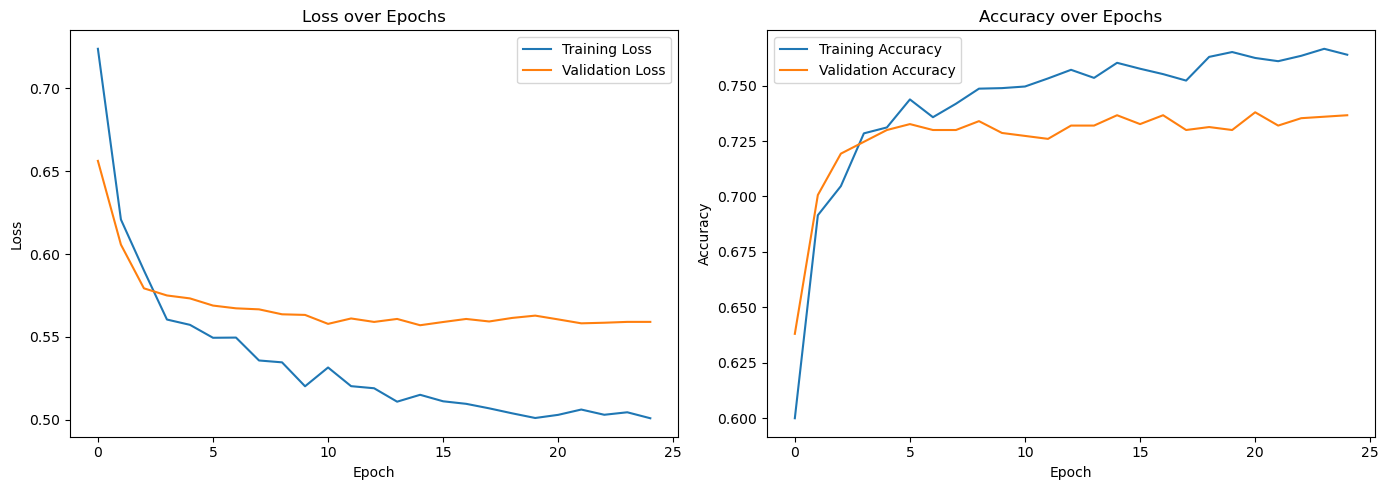

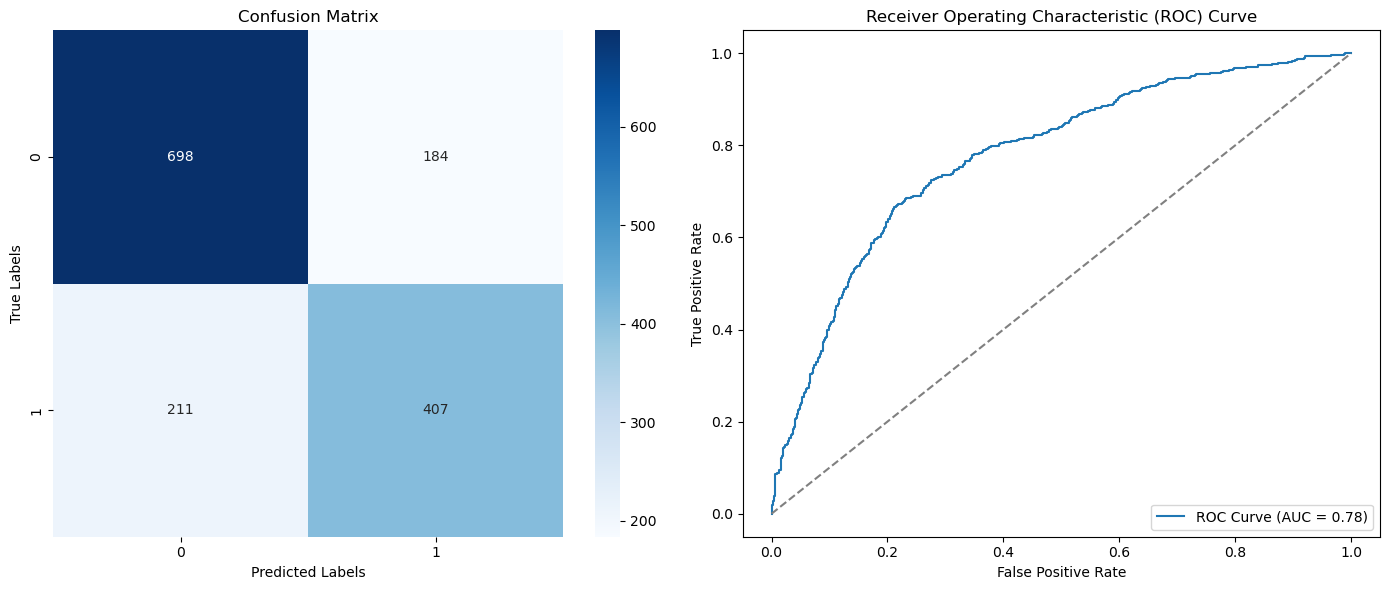

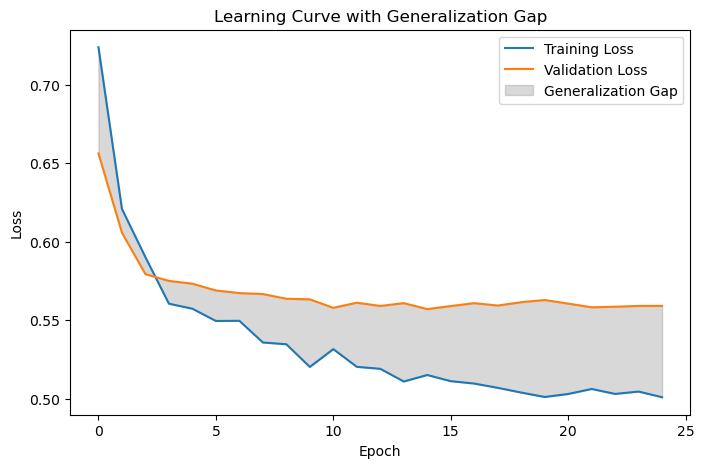

Decision boundary plot skipped (input features > 2D).


In [221]:
# --- PART 2: Visualizations ---

# 1. Training vs Validation Loss and Accuracy
fig, axes = plt.subplots(1, 2, figsize=(14,5))

# Plot Loss
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_title('Loss over Epochs')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plot Accuracy
axes[1].plot(history.history['accuracy'], label='Training Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('Accuracy over Epochs')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Calculate ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# Confusion Matrix Plot
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted Labels')
axes[0].set_ylabel('True Labels')

# ROC Curve Plot
axes[1].plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
axes[1].plot([0, 1], [0, 1], linestyle='--', color='gray')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Receiver Operating Characteristic (ROC) Curve')
axes[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

# 4. Learning Curve with Generalization Gap
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.fill_between(
    range(len(history.history['loss'])),
    np.array(history.history['loss']),
    np.array(history.history['val_loss']),
    color='gray', alpha=0.3, label='Generalization Gap'
)
ax.set_title('Learning Curve with Generalization Gap')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

# 5. Decision Boundary (only for 2D features)
if X_res.shape[1] == 2:
    from matplotlib.colors import ListedColormap
    
    x_min, x_max = X_res[:, 0].min() - 1, X_res[:, 0].max() + 1
    y_min, y_max = X_res[:, 1].min() - 1, X_res[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = (Z > 0.5).astype(int)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8,6))
    plt.contourf(xx, yy, Z, cmap=ListedColormap(('lightblue', 'lightcoral')))
    plt.scatter(X_res[:, 0], X_res[:, 1], c=y_res, cmap=ListedColormap(('blue', 'red')))
    plt.title('Decision Boundary')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()
else:
    print("Decision boundary plot skipped (input features > 2D).")
